In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host="localhost",
                          username="root",
                          password="12345",
                          database="ecommerce")
cur=db.cursor()


#  List all unique cities where customers are located

In [36]:
query="""select distinct customer_city from customers"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['city'])
df.head()

,city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [8]:
query="""select  count(order_id) from orders where year(order_purchase_timestamp)=2017"""

cur.execute(query)

data=cur.fetchall()

"total orders placed in 2017 are",data[0][0]

('total orders placed in 2017 are', 90202)

#  Find the total sales per category.


In [16]:
query="""select  upper(products.product_category )category, 
round(sum(payments.payment_value),2) sales from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Category","Sales"])

In [17]:
df.head()

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33


# Calculate the percentage of orders that were paid in installments.


In [19]:
query="""select (sum(case when payment_installments >=1 then 1 else 0 end))/count(*)*100 from payments"""

cur.execute(query)
data=cur.fetchall()
"the percentage of orders that were paid in installments is",data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state. 


In [41]:
query="""select customer_state,count(customer_id) from customers group by customer_state"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_count"])

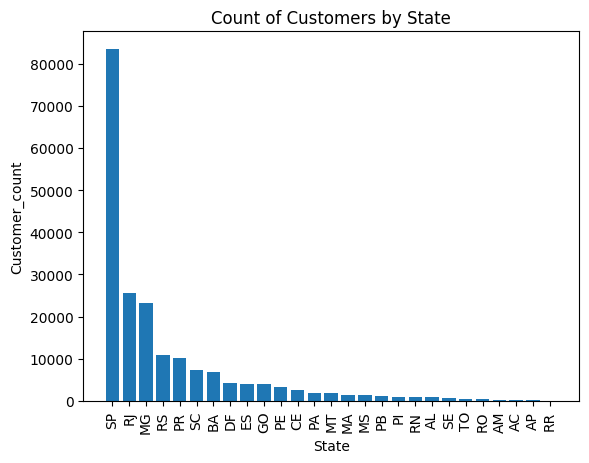

In [43]:
df_sorted=df.sort_values(by="customer_count",ascending=False)
plt.bar(df_sorted['state'],df_sorted['customer_count'])
plt.xlabel('State')
plt.ylabel('Customer_count')
plt.title('Count of Customers by State')

plt.xticks(rotation=90)
plt.show()

# Calculate the number of orders per month in 2018.

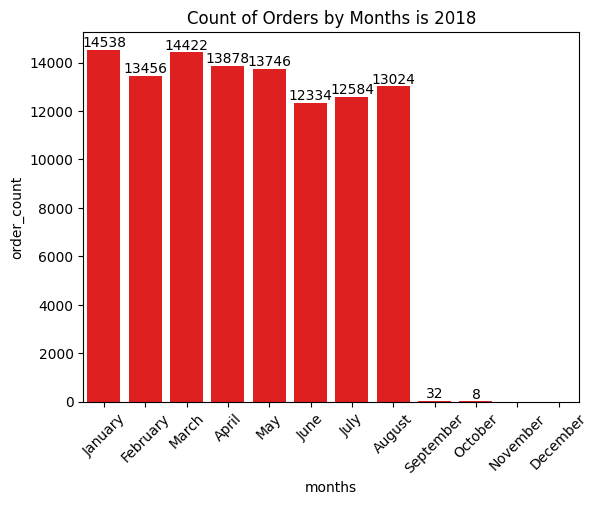

In [45]:
query="""select monthname(order_purchase_timestamp) months,count(order_id) order_count
from orders where year(order_purchase_timestamp)=2018 group by months"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["months","order_count"])

o=["January","February","March","April","May","June","July","August","September","October","November","December"]
ax=sns.barplot(x=df['months'],y=df['order_count'],data=df,order=o,color='red')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.title('Count of Orders by Months is 2018')
plt.show()

# Find the average number of products per order, grouped by customer city.

In [52]:
query="""with count_per_order as 
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order on
customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by average_orders DESC"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_city",average products per order"])
df.head(10)

,customer_city,average products per order
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
5,cidelandia,8.00
6,curralinho,8.00
7,picarra,8.00
8,morro de sao paulo,8.00
9,teixeira soares,8.00


#  Calculate the percentage of total revenue contributed by each product category.

In [60]:
query="""select  upper(products.product_category )category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category order by sales_percentage desc"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=['category','percentage_distribution'])
df.head(10)

,category,percentage_distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


#  Identify the correlation between product price and the number of times a product has been purchased.

In [61]:
query="""
select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=['category','order_count','price'])
df.head(10)

,category,order_count,price
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14
5,housewares,6964,90.79
6,electronics,2767,57.91
7,None,1603,112.00
8,toys,4117,117.55
9,bed table bath,11115,93.30


In [63]:
import pandas as pd
import numpy as np

In [66]:
arr1=df['order_count']
arr2=df['price']
a=np.corrcoef([arr1,arr2])
print('the correlation between price and number of times a product has been purchased is',a[0][1])

the correlation between price and number of times a product has been purchased is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [72]:
query="""
select *,dense_rank() over(order by revenue desc) as rn from 
(select order_items.seller_id,sum(payments.payment_value)
revenue from order_items join payments on order_items.order_id= payments.order_id group by order_items.seller_id) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['seller_id','revenue','rank'])
df.head(5)

,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5


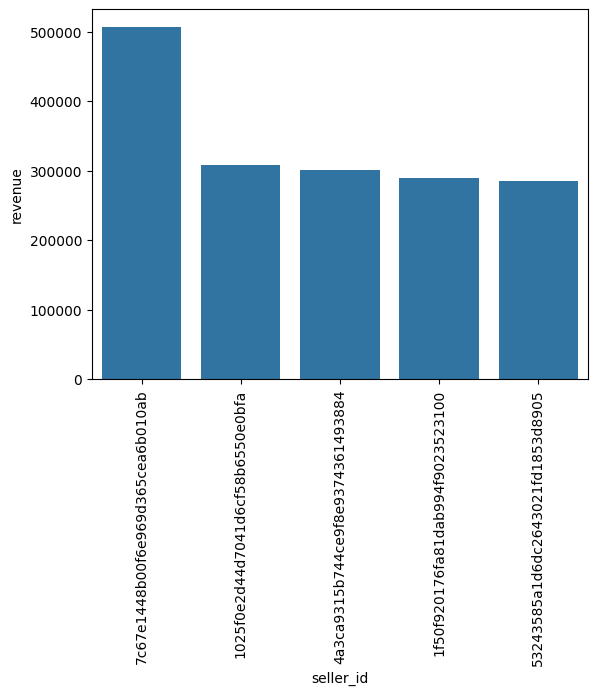

In [73]:
df=df.head()
sns.barplot(x="seller_id",y="revenue",data=df)
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [79]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df = df.drop_duplicates()
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
6,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
8,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
207763,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,27.120001
207764,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
207766,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.

In [80]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df


,0,1,2,3
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78
5,2017,3,899727.20,1879243.98
6,2017,4,835576.06,2714820.04
7,2017,5,1185837.64,3900657.68
8,2017,6,1022552.76,4923210.44
9,2017,7,1184765.84,6107976.28


# Calculate the year-over-year growth rate of total sales.

In [81]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [82]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

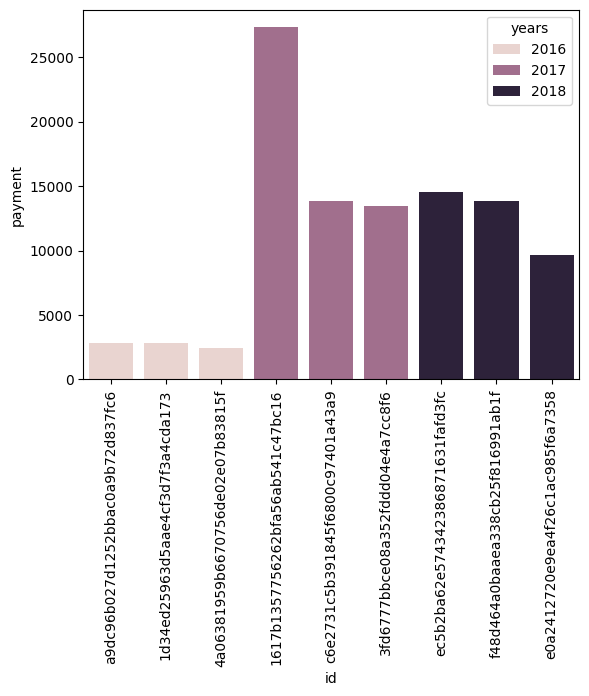

In [83]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()